<a href="https://colab.research.google.com/github/DressPD/electric_motion_forecast/blob/main/mimo_test_Schneider.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Schneider Electric Challenge**
---
*    Data Analytics for Application class
*    WiSe 22/23 - TUM
*    Prepared and developed by Aris Dressino, ...

In [1]:
# basic libraries needed
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
import copy
import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, TimeDistributed, Conv1D, MaxPooling1D, Flatten, Bidirectional, Input, Flatten, Activation, Reshape, RepeatVector, Concatenate
from tensorflow.keras.models import Model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from math import sqrt
from numpy import array

In [14]:
#set matplot size and random seeds
sns.set(rc={'figure.figsize':(20,10)})
tf.random.set_seed(42)

In [2]:
# colab package for file reading
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# reading files from Google Drive
data_hor_disc = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/DiscreteMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
data_hor_disc = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/DiscreteMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
data_hor_cont = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/ContinuousMotion_Data_Horizontalsetup.xlsx", sheet_name = "Sheet1")
data_ver_disc = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/DiscreteMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")
data_ver_cont = pd.read_excel("/content/drive/MyDrive/Schneider_Electric/schneider_electric_data/ContinuousMotion_Data_Verticalsetup.xlsx", sheet_name = "Tabelle1")
# use this in local environment
# data_hor_disc = pd.read_excel("path/", sheet_name="name")

## **exploratory data analysis and visualization**
---

1.   Summary statistics and head
2.   Visualization of continuous and discrete patterns per selected rotations per minute (RPM)
3. ... add something guys

In [4]:
data_hor_disc.head(5)

,Pow_100,Pow_200,Pow_300,Pow_400,Pow_500,Pow_600,Pow_700,Pow_800,Pow_900,Pow_1000,Pow_1100,Pow_1200,Pow_1300,Pow_1400,Pow_1500,Pow_1600,Pow_1700,Pow_1800,Pow_1900,Pow_2000
0,0.846,0.044,0.014,0.255,4.009,0.516,5.616,7.860,9.240,9.974999,10.981999,6.578000,12.059999,7.950,12.599,9.990001,9.555000,19.096001,13.938000,0.202
1,0.846,0.044,0.167,0.255,4.009,0.516,5.616,7.860,9.240,9.974999,10.981999,6.578000,12.059999,7.950,12.599,9.990001,9.555000,19.096001,13.938000,0.202
2,0.846,0.044,0.167,0.255,4.009,5.676,5.400,6.930,9.240,9.974999,9.728000,6.578000,11.834999,7.830,12.599,9.990001,10.465000,13.454000,11.039999,0.564
3,0.774,0.147,0.167,4.080,4.199,5.676,5.400,6.930,7.854,8.014999,9.728000,6.578000,11.834999,7.830,7.267,9.287000,10.465000,13.454000,11.039999,0.564
4,0.774,0.147,2.171,4.080,4.199,5.676,5.400,6.468,7.854,8.014999,9.472000,10.372999,11.834999,12.267,7.267,9.287000,15.548001,13.454000,11.280000,10.434


In [5]:
# descriptive statistics of discrete table
data_hor_disc.describe()
# as expected, we register increasing mean and standard deviation along with increased RPM

,Pow_100,Pow_200,Pow_300,Pow_400,Pow_500,Pow_600,Pow_700,Pow_800,Pow_900,Pow_1000,Pow_1100,Pow_1200,Pow_1300,Pow_1400,Pow_1500,Pow_1600,Pow_1700,Pow_1800,Pow_1900,Pow_2000
count,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000,45000.000000
mean,0.843142,1.249023,1.604354,1.951205,2.206332,2.493221,2.730921,2.848026,3.118614,3.295054,3.453644,3.577217,3.732571,3.902852,3.908951,4.052579,4.156900,4.182729,4.218840,4.217175
std,0.253721,0.579047,0.920542,1.298846,1.663406,2.058099,2.446147,2.785256,3.201309,3.574365,3.955490,4.300227,4.628946,5.014324,5.244952,5.600147,5.836061,5.949107,6.142617,6.150047
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.834000,1.332000,0.531000,0.294000,0.264000,0.265500,0.264000,0.244000,0.258000,0.264000,0.264000,0.238000,0.234000,0.256000,0.243000,0.255000,0.273000,0.256000,0.255000,0.270000
50%,0.900000,1.458000,2.040000,2.625000,3.204000,3.738000,2.873000,1.220000,0.828000,0.735000,0.606000,0.516000,0.458000,0.417000,0.486000,0.434500,0.426000,0.405000,0.417000,0.447000
75%,0.960000,1.575000,2.210000,2.896000,3.553000,4.242000,4.950000,5.655000,6.498750,7.310000,8.103001,8.639999,8.649000,8.613000,7.670001,7.525000,7.524000,7.560000,7.232000,7.175000
max,1.316000,2.360000,3.528000,5.100000,6.380000,7.608000,9.099999,9.641000,10.642000,11.375999,12.558001,13.631000,14.899000,16.224001,17.237999,19.139999,20.235001,22.019999,23.808001,23.487999


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Watts consumed per RPM in discrete motion')]

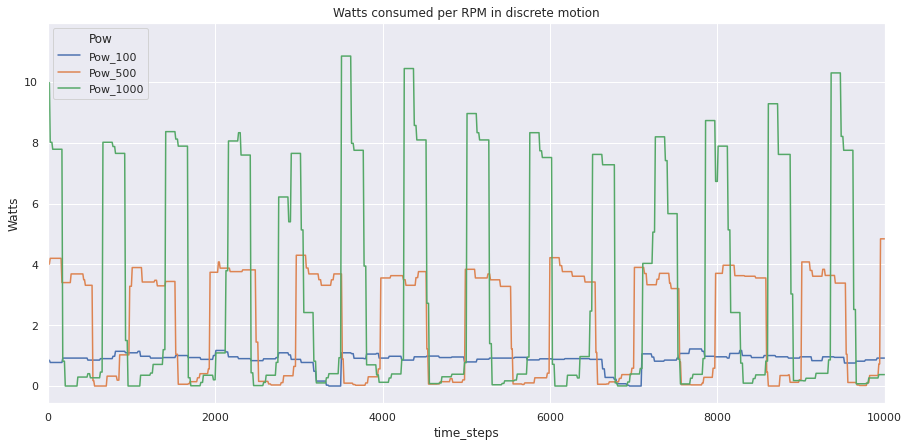

In [9]:
#add timesteps in ms for discrete tables
data_hor_disc['time_steps'] = range(0, 10*len(data_hor_disc), 10)
#data_hor_disc.head(10)
#plot melted table for discrete values
reference_pow=["Pow_100","Pow_500","Pow_1000"]
line_hor_disc = sns.lineplot("time_steps", "Watts", hue="Pow", hue_order=reference_pow,
             data=data_hor_disc.melt("time_steps", var_name="Pow", value_name="Watts"))
line_hor_disc.set_xlim(0,10000)
line_hor_disc.set(title='Watts consumed per RPM in discrete motion')

/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


[Text(0.5, 1.0, 'Watts consumed per RPM in continuous motion')]

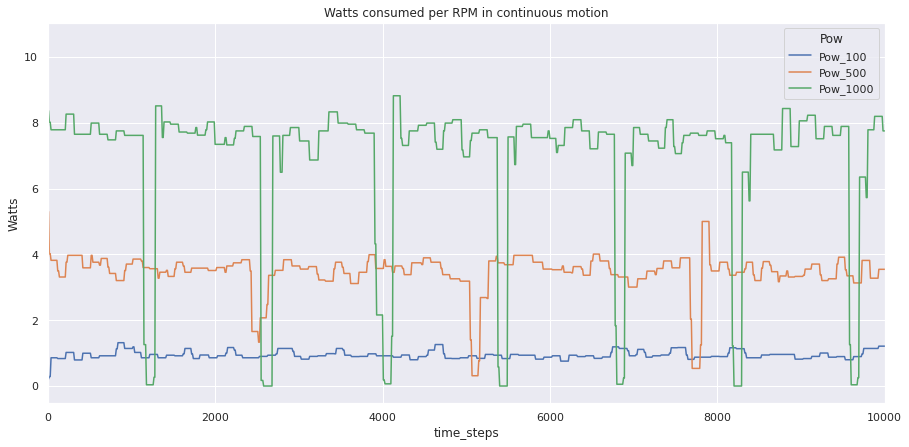

In [10]:
#add timesteps in ms to continuous table
data_hor_cont['time_steps'] = range(0, 10*len(data_hor_cont), 10)
#data_hor_cont.head(10)
#plot melted table for continuous values
reference_pow=["Pow_100","Pow_500","Pow_1000"]
line_hor_cont = sns.lineplot("time_steps", "Watts", hue="Pow", hue_order=reference_pow,
             data=data_hor_cont.melt("time_steps", var_name="Pow", value_name="Watts"))

#time_steps\PoW\watts
#(10-45000)x20\RPM_100 to RPM_2000->1-20\ x to x_2000

line_hor_cont.set_xlim(0,10000)
line_hor_cont.set(title='Watts consumed per RPM in continuous motion')

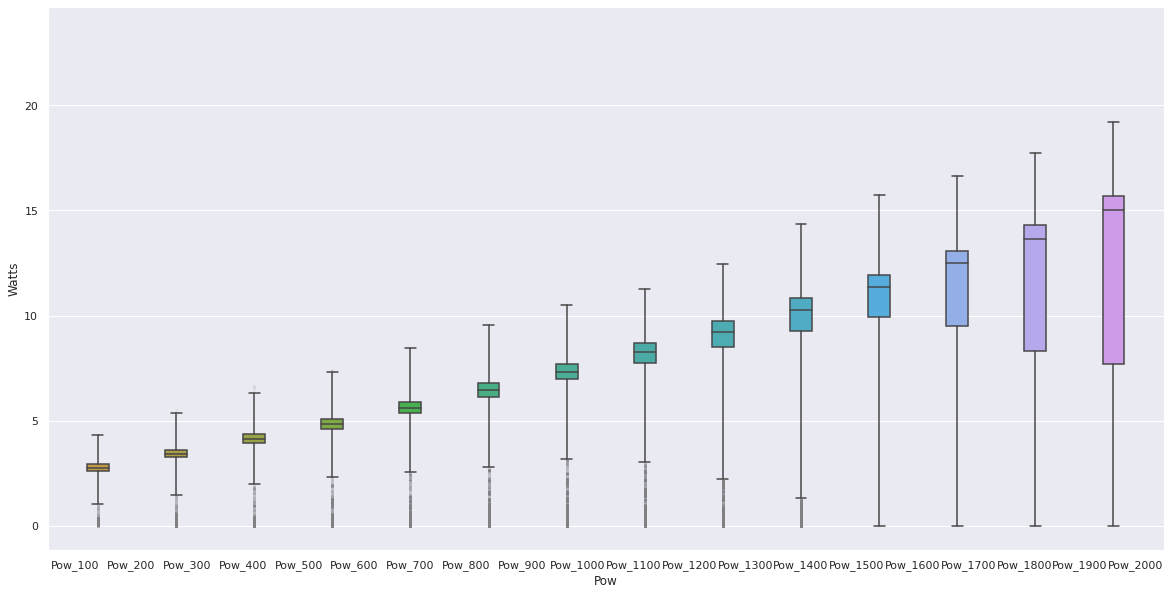

In [15]:
# boxplots of RPM distributions per RPM category
# increasing mean and variance are observable in our data

flierprops = dict(marker='x', markerfacecolor='None', markersize=2,  markeredgecolor='grey', alpha=0.01)
bp = sns.boxplot(x="Pow", y="Watts", hue="Pow", width=8, whis=5, flierprops=flierprops, data=data_hor_cont.melt("time_steps", var_name="Pow", value_name="Watts")) 
bp.legend([],[], frameon=False)

[Text(0, 0.5, 'Range of Power Consumption'),
 Text(0.5, 0, 'Speed'),
 Text(0.5, 1.0, 'Statistical Range of Power Consumption over Speed')]

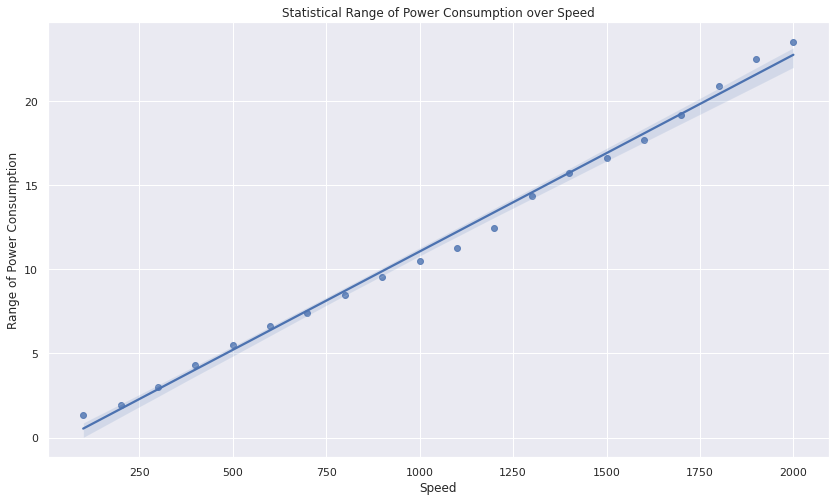

In [16]:
# drop time_steps columns
data_hor_disc.drop(columns=['time_steps'], inplace=True)
data_hor_cont.drop(columns=['time_steps'], inplace=True)

# list of horizontal continuous columns
columns_hor_cont = list(data_hor_cont.columns)
speeds_hor_cont = []
for speed in columns_hor_cont:
  speed = int(speed[4:])
  speeds_hor_cont.append(speed)
# print(speeds_hor_cont)

range_hor_cont = []
for label, content in data_hor_cont.items():
  range_hor_cont.append(abs(content.max() - content.min()))
# print(range_hor_cont)

sns.set(rc={'figure.figsize':(14,8)})
sns.regplot(x=speeds_hor_cont, y=range_hor_cont).set(xlabel="Speed", ylabel="Range of Power Consumption", title="Statistical Range of Power Consumption over Speed")

## **data preparation** for LSTM model
---

In [37]:
from sklearn.preprocessing import MinMaxScaler
power_list = [i for i in data_hor_disc.columns]
scaler = MinMaxScaler()

perc=0.7


# Splitting the dataset into train and test --> 70% in length is used for train
df_train=data_hor_disc.head(int(len(data_hor_disc)*perc))
df_test=data_hor_disc.head(int(len(data_hor_disc)*(1-perc)))

scaled_train = scaler.fit_transform(df_train[power_list])
scaled_test = scaler.transform(df_test[power_list])

#control nan in scaled datasets
print(np.isnan(scaled_train.max()))
print(np.isnan(scaled_test.max()))

False
False


In [18]:
def split_sequence(sequence, look_back, forecast_horizon):
    X, y = list(), list()
    for i in range(len(sequence)): 
        lag_end = i + look_back
        forecast_end = lag_end + forecast_horizon
        if forecast_end > len(sequence):
            break
        seq_x, seq_y = sequence[i:lag_end], sequence[lag_end:forecast_end]
        X.append(seq_x)
        y.append(seq_y)
        
    return np.array(X), np.array(y)

In [19]:
#function to evaluate forecast with test values and provide mae/mse/mape of the predictions
def evaluate_forecast(y_test_inverse, yhat_inverse):
    mse_ = tf.keras.losses.MeanSquaredError()
    mae_ = tf.keras.losses.MeanAbsoluteError()
    mape_ = tf.keras.losses.MeanAbsolutePercentageError()
    mae = mae_(y_test_inverse,yhat_inverse)
    print('mae:', mae)
    mse = mse_(y_test_inverse,yhat_inverse)
    print('mse:', mse)
    mape = mape_(y_test_inverse,yhat_inverse)
    print('mape:', mape)

In [20]:
LOOK_BACK=500
FORECAST_RANGE=1
n_features=len(power_list)

X_train, y_train = split_sequence(scaled_train, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
X_test, y_test = split_sequence(scaled_test, look_back=LOOK_BACK, forecast_horizon=FORECAST_RANGE)
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(30999, 500, 20)
(30999, 1, 20)
(13000, 500, 20)
(13000, 1, 20)


In [21]:
#reshape matrices with inverse transform
def inverse_transform(y_test, yhat):
  y_test_reshaped = y_test.reshape(-1, y_test.shape[-1])
  yhat_reshaped = yhat.reshape(-1, yhat.shape[-1])
  yhat_inverse = scaler.inverse_transform(yhat_reshaped)
  y_test_inverse = scaler.inverse_transform(y_test_reshaped)
  return yhat_inverse, y_test_inverse

## Time series **models fitting**
---


In [22]:
epochs = 1 #5 or +
batch_size = 32
validation = 0.1

In [23]:
checkpoint_filepath = 'path_to_checkpoint_filepath'
checkpoint_callback = ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=False,
    monitor='val_loss',
    mode='min',
    save_best_only=True)
early_stopping_callback = EarlyStopping(
    monitor='val_loss',
    min_delta=0.005,
    patience=10,
    mode='min'
)
rlrop_callback = ReduceLROnPlateau(monitor='val_loss', factor=0.2, mode='min', patience=3, min_lr=0.001)

In [24]:
## basic Encoder - Decoder Model
model_enc_dec = Sequential()
model_enc_dec.add(LSTM(100, activation='tanh', input_shape=(LOOK_BACK, n_features)))
model_enc_dec.add(RepeatVector(FORECAST_RANGE))
model_enc_dec.add(LSTM(100, activation='tanh', return_sequences=True))
model_enc_dec.add(TimeDistributed(Dense(n_features)))
model_enc_dec.compile(optimizer='adam', loss='mse')

plot_model(model=model_enc_dec, show_shapes=True)
history = model_enc_dec.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_enc_dec.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

872/872 [==============================] - ETA: 0s - loss: 0.0184

872/872 [==============================] - 207s 233ms/step - loss: 0.0184 - val_loss: 0.0080 - lr: 0.0010
mae: tf.Tensor(0.59355175, shape=(), dtype=float32)
mse: tf.Tensor(1.9683332, shape=(), dtype=float32)
mape: tf.Tensor(19969974.0, shape=(), dtype=float32)


In [27]:
## CNN-LSTM Encoder - Decoder Model

model_enc_dec_cnn = Sequential()
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=9, activation='relu', input_shape=(LOOK_BACK, n_features)))
model_enc_dec_cnn.add(Conv1D(filters=64, kernel_size=11, activation='relu'))
model_enc_dec_cnn.add(MaxPooling1D(pool_size=2))
model_enc_dec_cnn.add(Flatten())
model_enc_dec_cnn.add(RepeatVector(FORECAST_RANGE))
model_enc_dec_cnn.add(LSTM(200, activation='relu', return_sequences=True))
model_enc_dec_cnn.add(TimeDistributed(Dense(100, activation='relu')))
model_enc_dec_cnn.add(TimeDistributed(Dense(n_features)))
model_enc_dec_cnn.compile(loss='mse', optimizer='adam')

#plot_model(model=model_enc_dec_cnn, show_shapes=True)
#history = model_enc_dec_cnn.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
#yhat = model_enc_dec_cnn.predict(X_test, verbose=0)
#yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
#evaluate_forecast(y_test_inverse, yhat_inverse)

872/872 [==============================] - 167s 190ms/step - loss: 0.0213 - val_loss: 0.0275 - lr: 0.0010
mae: tf.Tensor(0.9614117, shape=(), dtype=float32)
mse: tf.Tensor(2.2410986, shape=(), dtype=float32)
mape: tf.Tensor(38326348.0, shape=(), dtype=float32)


In [26]:
## Vector Output Model

input_layer = Input(shape=(LOOK_BACK, n_features)) 
conv = Conv1D(filters=4, kernel_size=7, activation='relu')(input_layer)
conv = Conv1D(filters=6, kernel_size=11, activation='relu')(conv)
lstm = LSTM(100, return_sequences=True, activation='relu')(conv)
dropout = Dropout(0.2)(lstm)
lstm = LSTM(100, activation='relu')(dropout)
dense = Dense(FORECAST_RANGE*n_features, activation='relu')(lstm)
output_layer = Reshape((FORECAST_RANGE,n_features))(dense)
model_vector_output = Model([input_layer], [output_layer])
model_vector_output.compile(optimizer='adam', loss='mse')

plot_model(model=model_vector_output, show_shapes=True)
history = model_vector_output.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = model_vector_output.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)

In [34]:
from keras import backend as K

#swish custom function for time series analysis
def swish(x, beta = 1.0):
        return (K.sigmoid(beta * x) * x)

In [38]:
#Multi-Head CNN-LSTM Model -> loop for features
#https://towardsdatascience.com/cnn-lstm-based-models-for-multiple-parallel-input-and-multi-step-forecast-6fe2172f7668

input_layer = Input(shape=(LOOK_BACK, n_features)) 
head_list = []
for i in range(0, n_features):
 conv_layer_head = Conv1D(filters=4, kernel_size=7, activation=swish)(input_layer)
 conv_layer_head_2 = Conv1D(filters=6, kernel_size=11, activation=swish)(conv_layer_head)
 conv_layer_flatten = Flatten()(conv_layer_head_2)
 head_list.append(conv_layer_flatten)
 
concat_cnn = Concatenate(axis=1)(head_list)
reshape = Reshape((head_list[0].shape[1], n_features))(concat_cnn)
lstm = LSTM(100, activation=swish)(reshape)
repeat = RepeatVector(FORECAST_RANGE)(lstm)
lstm_2 = LSTM(100, activation=swish, return_sequences=True)(repeat)
dropout = Dropout(0.2)(lstm_2)
dense = Dense(n_features, activation="linear")(dropout)
multi_head_cnn_lstm_model = Model(inputs=input_layer, outputs=dense)

multi_head_cnn_lstm_model.compile(loss='mean_squared_error', optimizer='adam')

plot_model(model=multi_head_cnn_lstm_model, show_shapes=True)
history = multi_head_cnn_lstm_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=validation,callbacks=[early_stopping_callback, checkpoint_callback, rlrop_callback])
yhat = multi_head_cnn_lstm_model.predict(X_test, verbose=0)
yhat_inverse, y_test_inverse = inverse_transform(y_test, yhat)
evaluate_forecast(y_test_inverse, yhat_inverse)


872/872 [==============================] - 1660s 2s/step - loss: 0.0848 - val_loss: 0.0746 - lr: 0.0010
mae: tf.Tensor(3.143571, shape=(), dtype=float32)
mse: tf.Tensor(16.633686, shape=(), dtype=float32)
mape: tf.Tensor(166249630.0, shape=(), dtype=float32)


## **evaluation** of model metrics and precision
---

In [39]:
#last model run
mape_ = tf.keras.losses.MeanAbsolutePercentageError()
#predict model values
y_test_inverse_time_step = y_test_inverse.reshape(int(y_test_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, y_test_inverse.shape[-1])
yhat_inverse_time_step = yhat_inverse.reshape(int(yhat_inverse.shape[0]/FORECAST_RANGE), FORECAST_RANGE, yhat_inverse.shape[-1])
# yhat_inverse_time_step and y_test_inverse_time_step are both same dimension.
time_step_list_yhat = [[] for i in range(FORECAST_RANGE)]
time_step_list_y_test = [[] for i in range(FORECAST_RANGE)]
for i in range(0, yhat_inverse_time_step.shape[0]):
 for j in range(0, yhat_inverse_time_step.shape[1]):
    time_step_list_yhat[j].append(list(yhat_inverse_time_step[i][j]))
 time_step_list_y_test[j].append(list(y_test_inverse_time_step[i][j]))
yhat_time_step = np.array(time_step_list_yhat)
yhat_time_step = yhat_time_step.reshape(yhat_time_step.shape[0], -1)
yhat_time_step = tf.convert_to_tensor(yhat_time_step, dtype=tf.int64) 
y_test_time_step = np.array(time_step_list_y_test)
y_test_time_step = y_test_time_step.reshape(y_test_time_step.shape[0], -1)
y_test_time_step = tf.convert_to_tensor(y_test_time_step, dtype=tf.int64) 
# plotting
mape_list = []
for i in range(0, FORECAST_RANGE):
 mape = mape_(y_test_time_step[i], yhat_time_step[i])
 mape_list.append(mape)
plt.plot(range(0, FORECAST_RANGE), mape_list, marker='o')
plt.xticks((range(0, FORECAST_RANGE)))
plt.xlabel('Forecast Range')
plt.ylabel('MAPE') 

TypeError: ignored